In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import pathlib

In [3]:
batch_size = 32
img_width, img_height = 256, 256
data_dir_potato = '/content/drive/MyDrive/Colab Notebooks/leaf classification/Traning set photho'

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_potato,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [5]:
classes = ds.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


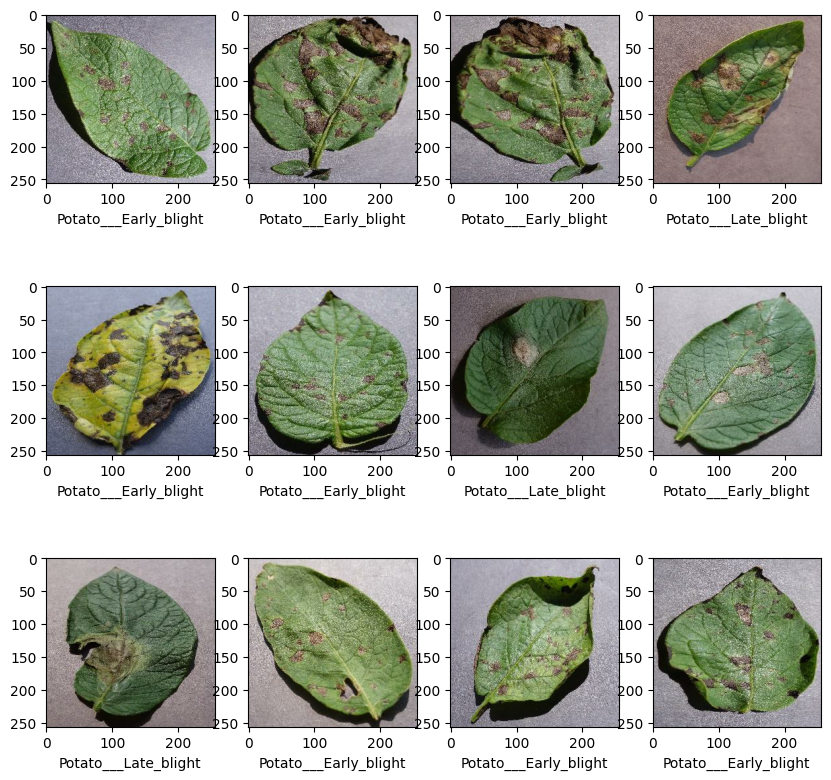

In [7]:
plt.figure(figsize=(10,10))
for  x, y  in ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.xlabel(classes[y[i].numpy()])

This show the numbers of baches:


In [8]:
bach_num = len (ds)
bach_num

68

In [9]:
num_traning_set = int(0.75 * bach_num)
num_val_set = int(0.1 * bach_num)
print(num_traning_set)
print(num_val_set)
num_test_set = bach_num - num_traning_set - num_val_set

51
6


In [10]:
traning_ds = ds.take(num_traning_set)
remain_data = ds.skip(num_traning_set)
val_ds = remain_data.take(num_val_set)
test_ds = remain_data.skip(num_val_set)

In [11]:
len(test_ds)

11

In [12]:
# Use data augmentation only on the training set
data_augmentation = tf.keras.Sequential([
     keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])

traning_ds = traning_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


# Resize and rescale all datasets.
resize_and_rescale = tf.keras.Sequential([
     keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
     keras.layers.experimental.preprocessing.Rescaling(1./255),
    ])

In [13]:
  # Use buffered prefetching and caching on all datasets.

traning_ds = traning_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# Model Architecture

model = keras.models.Sequential([
    resize_and_rescale,      # Resize and rescale all datasets.
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3) , input_shape = (batch_size, img_height, img_width, 3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(len(classes), activation = 'softmax'),
])

In [15]:
model.build(input_shape=(batch_size, img_height, img_width, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 64, 64, 64)         

In [16]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [17]:
history = model.fit(traning_ds, batch_size=batch_size, validation_data=val_ds,verbose=1, epochs= 20)

Epoch 1/20
51/51 [==============================] - 298s 5s/step - loss: 0.8178 - accuracy: 0.5790 - val_loss: 0.6855 - val_accuracy: 0.7344
Epoch 2/20
51/51 [==============================] - 249s 5s/step - loss: 0.5352 - accuracy: 0.7941 - val_loss: 0.3740 - val_accuracy: 0.8646
Epoch 3/20
51/51 [==============================] - 243s 5s/step - loss: 0.4116 - accuracy: 0.8346 - val_loss: 0.3463 - val_accuracy: 0.8542
Epoch 4/20
51/51 [==============================] - 243s 5s/step - loss: 0.2901 - accuracy: 0.8897 - val_loss: 0.3601 - val_accuracy: 0.8385
Epoch 5/20
51/51 [==============================] - 240s 5s/step - loss: 0.3770 - accuracy: 0.8744 - val_loss: 0.2464 - val_accuracy: 0.9219
Epoch 6/20
51/51 [==============================] - 240s 5s/step - loss: 0.2003 - accuracy: 0.9222 - val_loss: 0.3729 - val_accuracy: 0.8646
Epoch 7/20
51/51 [==============================] - 239s 5s/step - loss: 0.1780 - accuracy: 0.9338 - val_loss: 0.1681 - val_accuracy: 0.9219
Epoch 8/20
51

In [18]:
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100}")

11/11 [==============================] - 17s 1s/step - loss: 0.1745 - accuracy: 0.9573
Test Accuracy: 95.7317054271698


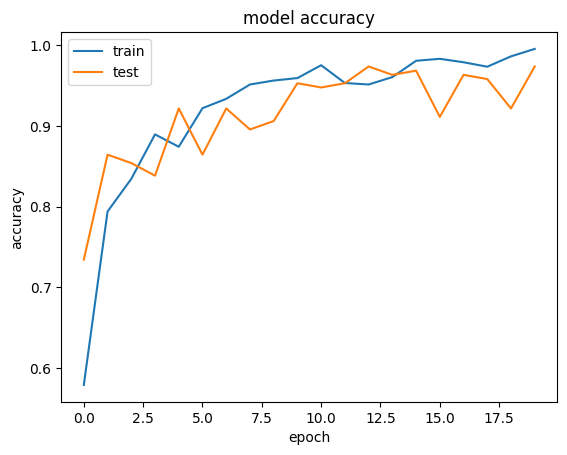

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

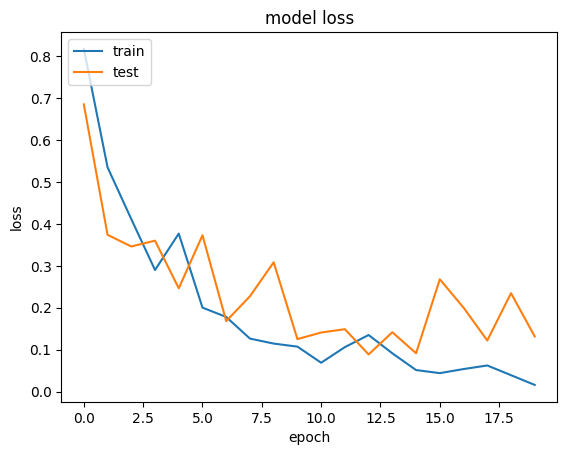

In [20]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
predicted label: Potato___Early_blight


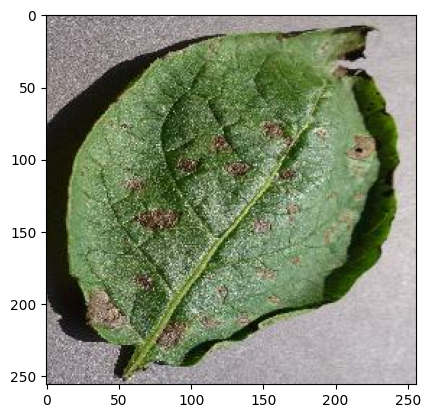

In [24]:
# Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch of it

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


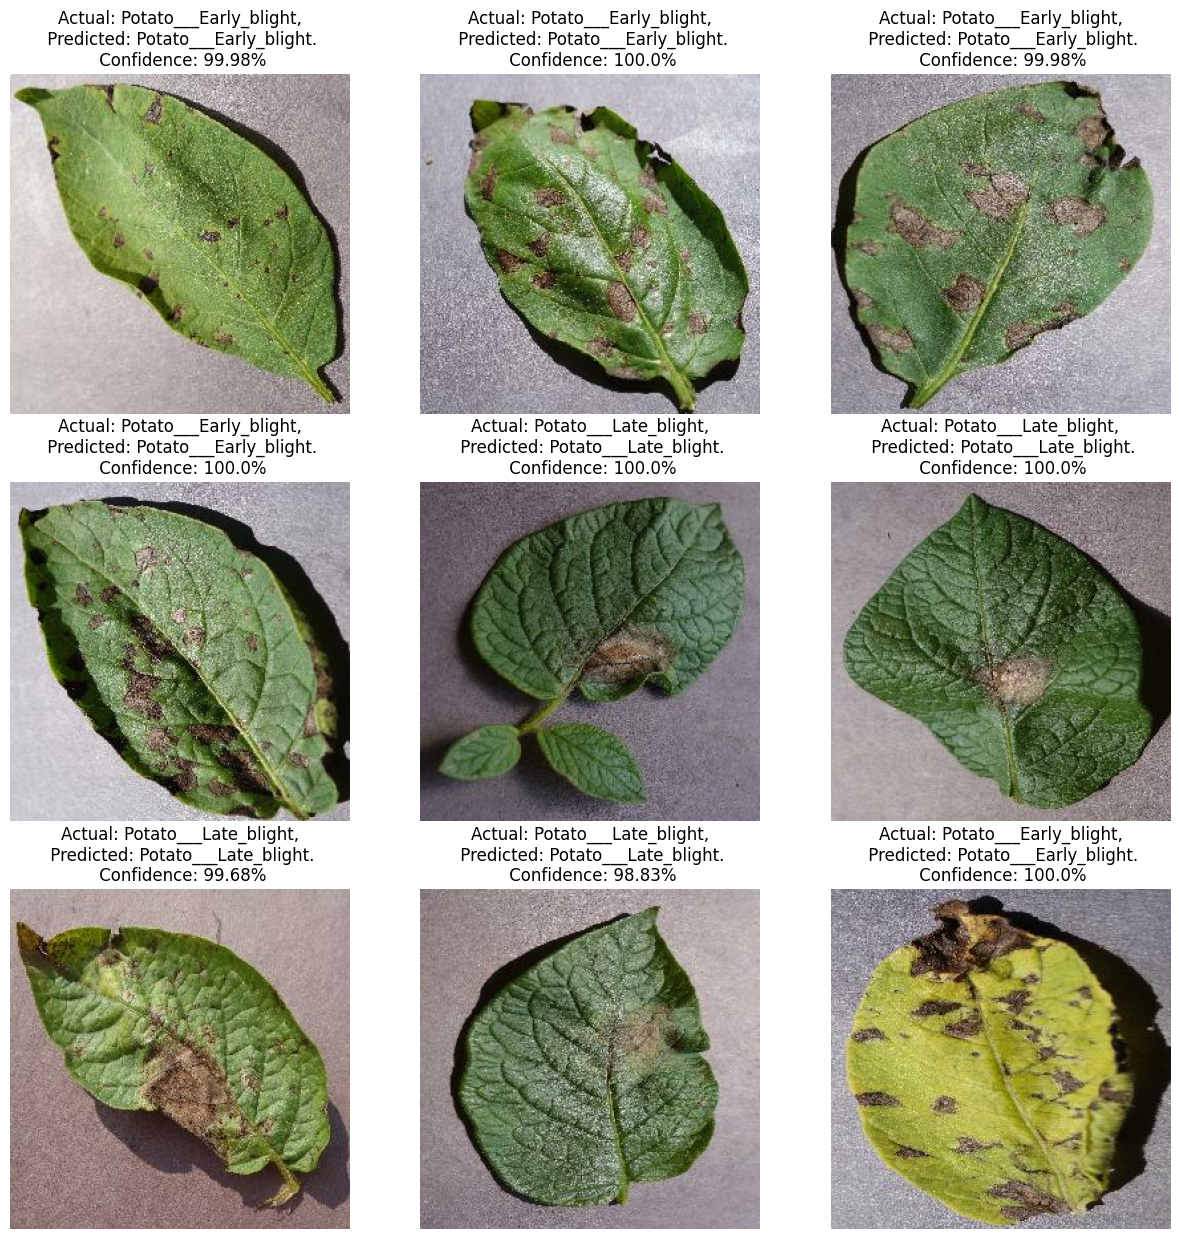

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [30]:
model.save("./potatoes.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
